# Gender Classification and Eyes Location Detection: A Two Task Problem

In this example, we are going to implement a multi-task problem. We try to identify the gender of the people, as well as locating their eyes in the image. Hence, we have two different tasks: classification (to identify the gender) and regression (to find the location of the eyes). We are going to use a single network (A CNN) to perform both tasks, however, we will need to apply different loss functions, each proper to a specific task. For this example we will need to install a few libraries. If you don't have them, they can be installed as below:

In [1]:
%pip install poutyne          # to install the Poutyne library
%pip install wget             # to install the wget library in order to download data
#%pip install opencv-python    # to install the cv2 (opencv) library

     |████████████████████████████████| 136 kB 3.9 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9673 sha256=a07a469bfdf051347d924a5399968c075da872ad8147c0597da1ea6c6e8caf3b
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


Let’s import all the needed packages.

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import math
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wget
import zipfile
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as tfms
from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment, StepLR
from torch.utils.data import DataLoader, Subset, Dataset  
from torchvision.utils import make_grid


## Training Constants

In [3]:
num_epochs = 15
learning_rate = 0.001
batch_size = 32
image_size = 224
w, h = 218, 178   # the width and the hight of original images before resizing
valid_split_percent = 0.1  
momentum = 0.5
set_seeds(42)
imagenet_mean = [0.485, 0.456, 0.406]  # mean of the ImageNet dataset for normalizing 
imagenet_std = [0.229, 0.224, 0.225]  # std of the ImageNet dataset for normalizing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('The running processor is...', device) 

The running processor is... cuda


## CelebA Dataset

We are going to use CelebA dataset for this experiment. The CelebA 
dataset  is a large-scale face attributes dataset which can be employed as the training and test sets for the following computer vision tasks: face attribute recognition, face detection, landmark (or facial part) localization, and face editing & synthesis.

## Fetching data 


The section below consists of a few lines of codes that help us download celebA dataset from a public web source and unzip them. Downloading the Celeba dataset can be also done directly by `torch.datasets.CelebA(data_root, download =  True)`. however, due to the high traffic of Google Drive ( the main source of the dataset) it usually fails to function. hence we decided to download it from another public source but use it with `torch.datasets.CelebA()`.

In [4]:
data_root = 'datasets'  

base_url = "https://graal.ift.ulaval.ca/public/celeba/"

file_list = [
    "img_align_celeba.zip",
    "list_attr_celeba.txt", 
    "identity_CelebA.txt",
    "list_bbox_celeba.txt",
    "list_landmarks_align_celeba.txt",
    "list_eval_partition.txt"
]

# Path to folder with the dataset
dataset_folder = f'{data_root}/celeba'
os.makedirs(dataset_folder, exist_ok=True)

for file in file_list:
    url = f"{base_url}/{file}"
    if not os.path.exists(f"{dataset_folder}/{file}"):
      wget.download(url, f"{dataset_folder}/{file}")

with zipfile.ZipFile(f"{dataset_folder}/img_align_celeba.zip", 'r') as ziphandler:
    ziphandler.extractall(dataset_folder)

Now, as the dataset id downloaded, we can define our datasets and dataloaders in its original way.

In [9]:
transforms = tfms.Compose ([
                           tfms.Resize((image_size, image_size)),
                           tfms.ToTensor(),
                           tfms.Normalize(imagenet_mean, imagenet_std)
])
train_dataset = datasets.CelebA(data_root, 
                                split='train', 
                                target_type=['attr', 'landmarks'], 
                                transform=transforms)
valid_dataset = datasets.CelebA(data_root, 
                                split='valid', 
                                target_type=['attr', 'landmarks'], 
                                transform=transforms)
test_dataset = datasets.CelebA(data_root, 
                               split='test', 
                               target_type=['attr', 'landmarks'], 
                               transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Here we can see how each dataset sample looks like:

In [6]:
print (train_dataset[0])

(tensor([[[ 2.2147,  2.2147,  2.2147,  ...,  2.1735,  2.2318,  2.2318],
         [ 2.2147,  2.2147,  2.2147,  ...,  2.1894,  2.2318,  2.2318],
         [ 2.2147,  2.2147,  2.2147,  ...,  2.2061,  2.2478,  2.2478],
         ...,
         [ 0.2681,  0.0091,  0.1427,  ..., -0.0333, -0.0333, -0.0333],
         [ 0.1345,  0.2426,  0.5284,  ..., -0.0965, -0.0958, -0.0958],
         [ 0.7591,  1.1856,  1.7172,  ..., -0.0796, -0.0629, -0.0629]],

        [[ 2.0084,  2.0084,  2.0084,  ...,  2.0287,  2.1310,  2.1310],
         [ 2.0084,  2.0084,  2.0084,  ...,  2.0451,  2.1310,  2.1310],
         [ 2.0084,  2.0084,  2.0084,  ...,  2.0780,  2.1473,  2.1473],
         ...,
         [-0.7543, -1.0417, -0.9152,  ..., -1.0703, -1.0612, -1.0612],
         [-0.9236, -0.8130, -0.5208,  ..., -1.1603, -1.1436, -1.1436],
         [-0.2850,  0.1511,  0.6945,  ..., -1.1689, -1.1604, -1.1604]],

        [[ 1.5768,  1.5768,  1.5768,  ...,  2.0903,  2.0648,  2.0648],
         [ 1.5768,  1.5768,  1.5768,  ...,  

Regarding the complexity of the problem and the high number training/valid samples, we can seperate and use a portion of data as below:

In [53]:
train_subset = Subset(train_dataset, np.arange(1,5000))
valid_subset = Subset(valid_dataset, np.arange(1,500))
train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)

Here, we can see an example from the training dataset. It shows an image of a person, printing the gender and also showing the location of the eyes. It is worth mentioning that as we resize the image, the coordinates of the eyes should also be changed with same ratio.

Gender is:  male


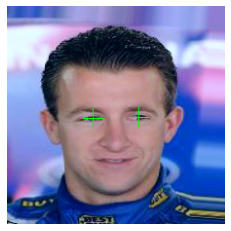

In [54]:
sample_number = 22
image = train_dataset[sample_number][0]
image = image.permute(1,2,0).detach().numpy()
image_rgb = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
image_rgb = image_rgb * imagenet_std + imagenet_mean
Gender = 'male' if int(train_dataset[sample_number][1][0][20])==1 else 'female'
print('Gender is: ', Gender)
w, h = 218, 178
(x_L, y_L) = train_dataset[sample_number][1][1][0:2]
(x_R, y_R) = train_dataset[sample_number][1][1][2:4]
w_scale = image_size/w
h_scale = image_size/h
x_L, x_R = (x_L*h_scale), (x_R*h_scale)  #rescaling for the size of (224,224) and finaly to the range of [0,1]
y_L, y_R = (y_L*w_scale), (y_R*w_scale)
x_L, x_R = int(x_L), int(x_R)
y_L, y_R = int(y_L), int(y_R)
image_rgb	= cv2.drawMarker(image_rgb, (x_L,y_L), (0,255,0))
image_rgb	= cv2.drawMarker(image_rgb, (x_R,y_R), (0,255,0))
image_rgb = cv2.cvtColor(np.float32(image_rgb), cv2.COLOR_BGR2RGB)
image_rgb = np.clip(image_rgb ,0 , 1)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

## Network

Below, we define a new class, named 'ClassifierLocalizer, which accepts a pre-trained CNN and changes its last fully connected layer to be proper for the two task problem. The new fully connected layer contains 6 neurons, 2 for the classification task (male or female) and 4 for the localization task (x and y for the left and right eyes). Moreover, to put the location results on the same scale as the class scores, we apply the sigmoid function to the neurons assigned for the localization task.

In [55]:
class ClassifierLocalizer(nn.Module):
    def __init__(self, model_name, num_classes=2):

      super(ClassifierLocalizer, self).__init__()
      self.num_classes = num_classes
      
      # create cnn model
      model = getattr(models, model_name)(pretrained=True)
      
      # remove fc layers and add a new fc layer
      num_features = model.fc.in_features
      model.fc = nn.Linear(num_features, 6) # classifier + localizer
      self.model = model
    
    def forward(self,X ):
        X = torch.tensor(X, requires_grad=True)
        x = self.model(X)                    # extract features from CNN
        scores = x[:, :self.num_classes]     # class scores
        coords = x[:, self.num_classes:]     # coordinates
        return [scores, torch.sigmoid(coords)]   # sigmoid output is in the range of [0, 1]

Regarding the complexity of the problem, the number of the samples in the training dataset, and the similarity of the training dataset to the ImageNet dataset, we may decide to freeze some of the layers. In our current example, based on the mentioned factors, we freeze just the last fully connected layer.

In [56]:
network = ClassifierLocalizer(model_name='resnet18')

def freeze_weights(network):
    for name, param in network.named_parameters():
        if not name.startswith('fc.'):
            param.requires_grad = False

freeze_weights(network)
print(network)

ClassifierLocalizer(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [50]:
network = ClassifierLocalizer(model_name='resnet18')  # network without freezing any layer.

## Loss function

As we discussed before, we have two different tasks in this example. These tasks need different loss functions; Cross-Entropy loss for the classification and Mean Square Error loss for the regression. Below, we define a new loss function class that sums both losses to considers them simultaneously. However, as the regression is relatively a harder task, we apply a higher weight to MSEloss.

In [57]:
class ClassificationRegressionLoss(nn.Module):
    def __init__(self):
        super(ClassificationRegressionLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss() # size_average=False
        self.mse_loss = nn.MSELoss()
        
    def forward(self, y_pred, y_true):
        loss_cls = self.ce_loss(y_pred[0], y_true[0][:,20]) # Cross Entropy Error (for classification)
        loss_reg1 = self.mse_loss(y_pred[1][:,0], Variable(y_true[1][:,0]/h, requires_grad=True)) # Mean Squared Error for X_L
        loss_reg2 = self.mse_loss(y_pred[1][:,1], Variable(y_true[1][:,1]/w, requires_grad=True)) # Mean Squared Error for Y_L
        loss_reg3 = self.mse_loss(y_pred[1][:,2], Variable(y_true[1][:,2]/h, requires_grad=True)) # Mean Squared Error for X_R
        loss_reg4 = self.mse_loss(y_pred[1][:,3], Variable(y_true[1][:,3]/w, requires_grad=True)) # Mean Squared Error for Y_R
        total_loss = loss_cls + loss_reg1 + loss_reg2 + loss_reg3 + loss_reg4
        return total_loss

## Training

In [58]:
optimizer = optim.SGD(network.parameters(), lr=0.001, weight_decay=0)
loss_function = ClassificationRegressionLoss()
exp = Experiment('./two_task_example25', network, optimizer=optimizer, loss_function=loss_function, device="all")
exp.train(train_dataloader, valid_dataloader, epochs=num_epochs)

Loading weights from ./two_task_example25/checkpoint.ckpt and starting at epoch 5.
Loading optimizer state from ./two_task_example25/checkpoint.optim and starting at epoch 5.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Epoch:  5/15 Train steps: 32 Val steps: 4 8.65s loss: 0.629847 val_loss: 0.666480 
Epoch 5: val_loss improved from 0.67946 to 0.66648, saving file to ./two_task_example25/checkpoint_epoch_5.ckpt
Epoch:  6/15 Train steps: 32 Val steps: 4 8.52s loss: 0.630810 val_loss: 0.666453 
Epoch 6: val_loss improved from 0.66648 to 0.66645, saving file to ./two_task_example25/checkpoint_epoch_6.ckpt
Epoch:  7/15 Train steps: 32 Val steps: 4 8.53s loss: 0.631290 val_loss: 0.665917 
Epoch 7: val_loss improved from 0.66645 to 0.66592, saving file to ./two_task_example25/checkpoint_epoch_7.ckpt
Epoch:  8/15 Train steps: 32 Val steps: 4 8.59s loss: 0.630419 val_loss: 0.665885 
Epoch 8: val_loss improved from 0.66592 to 0.66589, saving file to ./two_task_example25/checkpoint_epoch_8.ckpt
Epoch:  9/15 Train steps: 32 Val steps: 4 8.58s loss: 0.633988 val_loss: 0.665024 
Epoch 9: val_loss improved from 0.66589 to 0.66502, saving file to ./two_task_example25/checkpoint_epoch_9.ckpt
Epoch: 10/15 Train steps:

[{'epoch': 5,
  'loss': 0.6298471612853928,
  'time': 8.65485668500014,
  'val_loss': 0.666479822361108},
 {'epoch': 6,
  'loss': 0.6308098382897325,
  'time': 8.523329641000146,
  'val_loss': 0.6664525914673853},
 {'epoch': 7,
  'loss': 0.6312902576333888,
  'time': 8.525925591000032,
  'val_loss': 0.6659170039976486},
 {'epoch': 8,
  'loss': 0.6304193439187707,
  'time': 8.589758219000032,
  'val_loss': 0.6658853153989772},
 {'epoch': 9,
  'loss': 0.6339884044768455,
  'time': 8.5841192580001,
  'val_loss': 0.665023512912519},
 {'epoch': 10,
  'loss': 0.6246109237900009,
  'time': 8.56445765699982,
  'val_loss': 0.6657354903943611},
 {'epoch': 11,
  'loss': 0.6301360541993791,
  'time': 8.698706878999928,
  'val_loss': 0.6664875872207411},
 {'epoch': 12,
  'loss': 0.6329393254982697,
  'time': 8.594686492000164,
  'val_loss': 0.6652180859536836},
 {'epoch': 13,
  'loss': 0.6339961484865144,
  'time': 8.668061757000032,
  'val_loss': 0.6677656631277065},
 {'epoch': 14,
  'loss': 0.631

## Evaluation

As you have also noticed from the training logs, we have achieved the best performance (considering the validation loss) at the 15th epoch. The weights of the network for the corresponding epoch have been automatically saved and we use these parameters to evaluate our algorithm visually. Hence,  we take advantage of evaluate function of Poutyne, and apply it to the validation dataset. It provides us the predictions as well as the ground-truth for comparison, in case of need.

In [59]:
model = Model(network, optimizer, loss_function, device=device)
model.load_weights('./two_task_example25/checkpoint.ckpt')
loss, predictions, Ground_Truth = model.evaluate_generator(train_dataloader, return_pred=True, return_ground_truth=True)

Step:  1/32   3.12% |▋                   |ETA: 5.66s test_loss: 0.677317

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Test steps: 32 5.84s test_loss: 0.627271                                


In [61]:
logs = pd.read_csv('./two_task_example25/log.tsv', sep='\t')
print(logs)

    epoch       time     lr      loss  val_loss
0       1  50.238508  0.001  0.675908  0.679900
1       2  50.368700  0.001  0.645202  0.684492
2       3  50.487173  0.001  0.624674  0.698184
3       4  50.366303  0.001  0.608449  0.679459
4       5   8.654857  0.001  0.629847  0.666480
5       6   8.523330  0.001  0.630810  0.666453
6       7   8.525926  0.001  0.631290  0.665917
7       8   8.589758  0.001  0.630419  0.665885
8       9   8.584119  0.001  0.633988  0.665024
9      10   8.564458  0.001  0.624611  0.665735
10     11   8.698707  0.001  0.630136  0.666488
11     12   8.594686  0.001  0.632939  0.665218
12     13   8.668062  0.001  0.633996  0.667766
13     14   8.651599  0.001  0.631637  0.666518
14     15   8.665096  0.001  0.632026  0.665529


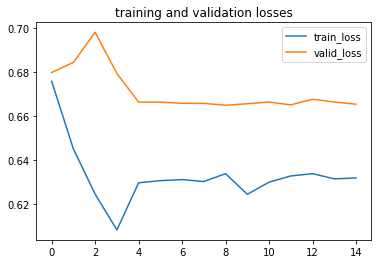

In [62]:
train_loss = logs.loss
valid_loss = logs.val_loss
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['train_loss','valid_loss'])
plt.title('training and validation losses')
plt.show()

We can also evaluate the performance of the trained network (a network with the best weights) on any dataset, as below:

In [63]:
exp.test(test_dataloader)

Found best checkpoint at epoch: 9
lr: 0.001, loss: 0.633988, val_loss: 0.665024
Loading checkpoint ./two_task_example25/checkpoint_epoch_9.ckpt
Running test
Step:   1/624   0.16% |                    |ETA: 117.35s test_loss: 0.728455

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


Test steps: 624 118.04s test_loss: 0.711588                               


{'test_loss': 0.7115875080417456, 'time': 118.03682371100058}

Now let's evaluate the performance of the network visually.

Gender is:  male


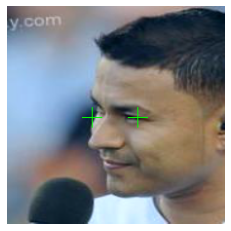

In [ ]:
sample_number = 35
image = train_dataset[sample_number][0]
image = image.permute(1,2,0).detach().numpy()
image_rgb = cv2.cvtColor(np.float32(image), cv2.COLOR_BGR2RGB)
image_rgb = image_rgb * imagenet_std + imagenet_mean
Gender = 'male' if np.argmax(predictions[0][sample_number])==0 else 'female'
print('Gender is: ', Gender)
(x_L, y_L) = predictions[1][sample_number][0:2]*image_size
(x_R, y_R) = predictions[1][sample_number][2:4]*image_size
x_L, x_R = int(x_L), int(x_R)
y_L, y_R = int(y_L), int(y_R)
image_rgb	= cv2.drawMarker(image_rgb, (x_L,y_L), (0,255,0))
image_rgb	= cv2.drawMarker(image_rgb, (x_R,y_R), (0,255,0))
image_rgb = cv2.cvtColor(np.float32(image_rgb), cv2.COLOR_BGR2RGB)
image_rgb = np.clip(image_rgb , 0, 1)
plt.imshow(image_rgb)
plt.axis('off')
plt.show()